В данном блокноте реализован pipeline обучения модели **YOLOv12m** на датасете **Microplastic Dataset**. \
Задача модели - распознавать микропластик под микроскопом.

# Установка зависимостей


In [ ]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# Импорты

## Библиотеки

In [ ]:
from ultralytics import YOLO # Конструктор модели
import torch # Очистка кэша

# Предобработка и конвертация данных
from roboflow import Roboflow

# Анализ данных выборок (EDA) и визуализация
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Визуализация примеров аугментации
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from random import choice

# Данные

**Датасет, используемый в данном блокноте:** \
https://universe.roboflow.com/panats-mp-project/microplastic-dataset/dataset/19 \
Данный датасет содержит 781 изображение (без учёта аугментации). Для обучения модели была использована 19 версия датасета, т.к. в 18 частицы микропластика были размечены кластерами, а не каждая по отдельности. Это сильно сказывается на способности модели определять отдельные частицы микропастика, что может быть критично в некоторых исследованиях.

Датасет 18 версии: \
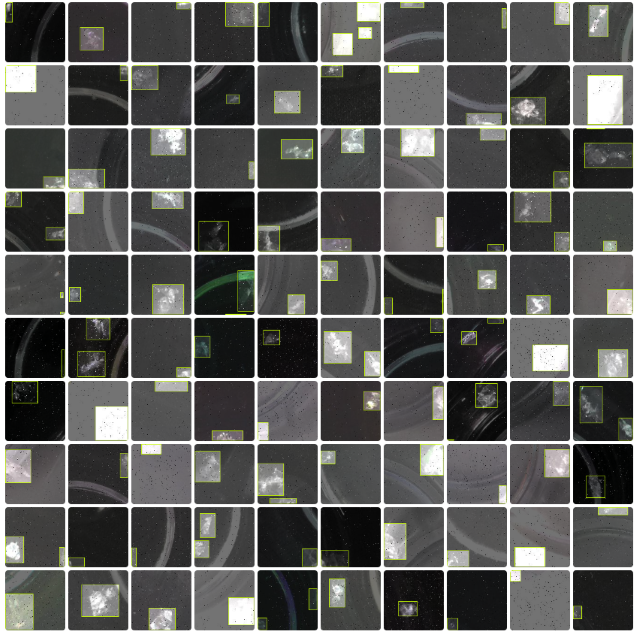

Датасет 19 версии: \
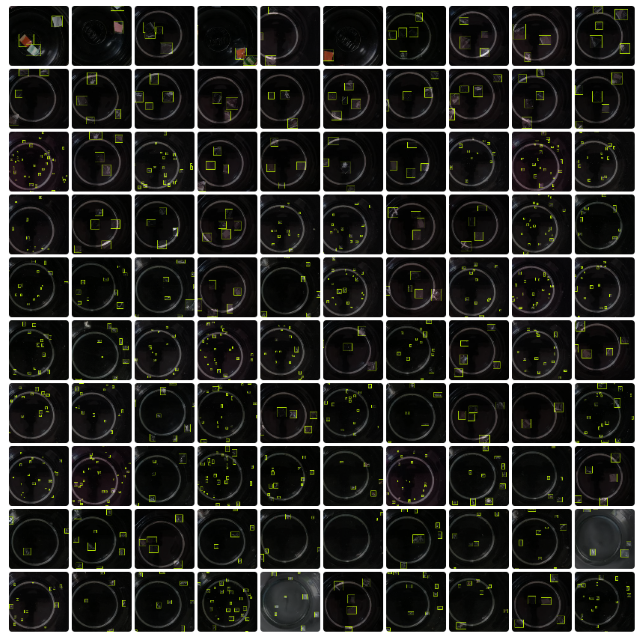

## Загрузка данных

In [ ]:
rf = Roboflow(api_key='API_KEY')
project = rf.workspace('panats-mp-project').project('microplastic-dataset')
dataset = project.version(19).download('yolov12')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Microplastic-Dataset-19 in yolov12:: 100%|██████████| 1571/1571 [00:00<00:00, 9302.95it/s]


## Анализ данных (EDA) и визуализация


Перед обучением модели данные необходимо тщательно проанализировать. Важно сохранять оптимальное разделение обучающей и тестовой выборок.
Помимо этого, нужно проверять правильность разметки.

### Размеры выборок

In [ ]:
# Пути к выборкам
train_dir = '/content/Microplastic-Dataset-19/train'
valid_dir = '/content/Microplastic-Dataset-19/valid'

train_images_dir = os.path.join(train_dir, 'images')
valid_images_dir = os.path.join(valid_dir, 'images')

train_labels_dir = os.path.join(train_dir, 'labels')
valid_labels_dir = os.path.join(valid_dir, 'labels')


# Подсчёт количества файлов с изображениями и разметкой
def count_files(images_dir, labels_dir):
    image_files = glob.glob(os.path.join(images_dir, '*.jpg')) + glob.glob(os.path.join(images_dir, '*.png'))
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))

    return image_files, label_files


train_imgs, train_lbls = count_files(train_images_dir, train_labels_dir)
valid_imgs, valid_lbls = count_files(valid_images_dir, valid_labels_dir)

print(f'Обучающая выборка: {len(train_imgs)} изображений, {len(train_lbls)} файлов разметки')
print(f'Валидационная выборка: {len(valid_imgs)} изображений, {len(valid_lbls)} файлов разметки')

Обучающая выборка: 577 изображений, 577 файлов разметки
Валидационная выборка: 204 изображений, 204 файлов разметки


### Визуализация размера выборок

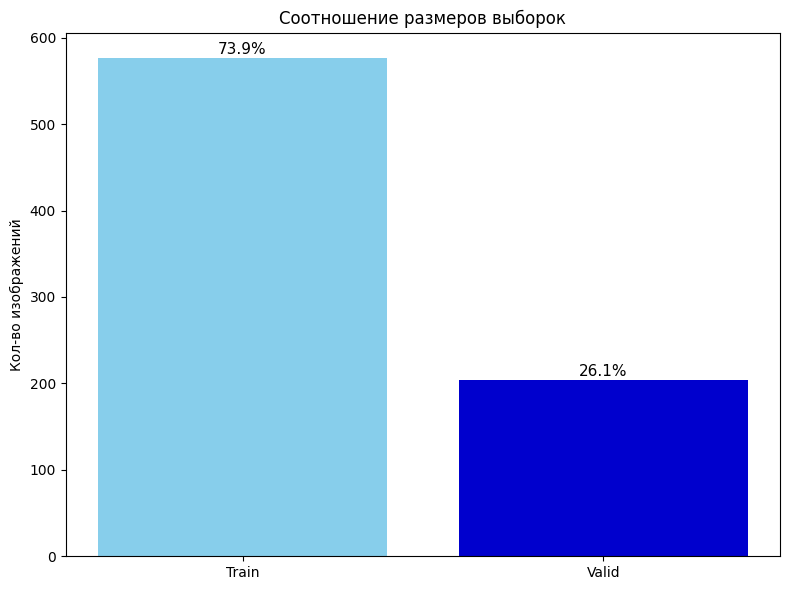

In [ ]:
# Подсчёт количества изображений в выборках
train_count = len(train_imgs)
valid_count = len(valid_imgs)
total = train_count + valid_count

# Данные и подписи
labels = ['Train', 'Valid']
values = [train_count, valid_count]
percentages = [v / total * 100 for v in values]

# Построение графика соотношения
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['skyblue', 'mediumblue'])
plt.title('Соотношение размеров выборок')
plt.ylabel('Кол-во изображений')

# Добавление процентов над столбцами
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percent:.1f}%',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

Исходя из графика, выборка имеет сбалансированное разделение на обучающую и тестовую части. Обычно используется разделение 80% / 20%, иногда 70% / 30%. Можно также использовать 90% / 10%, если данных слишком мало, но в данном случае это неуместно.


### Распределение экземпляров на изображениях

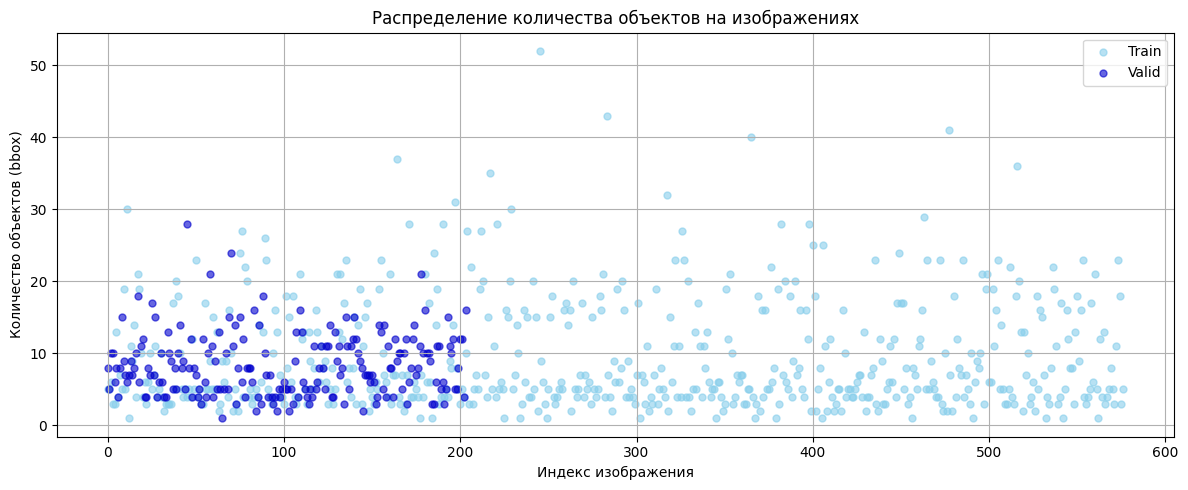

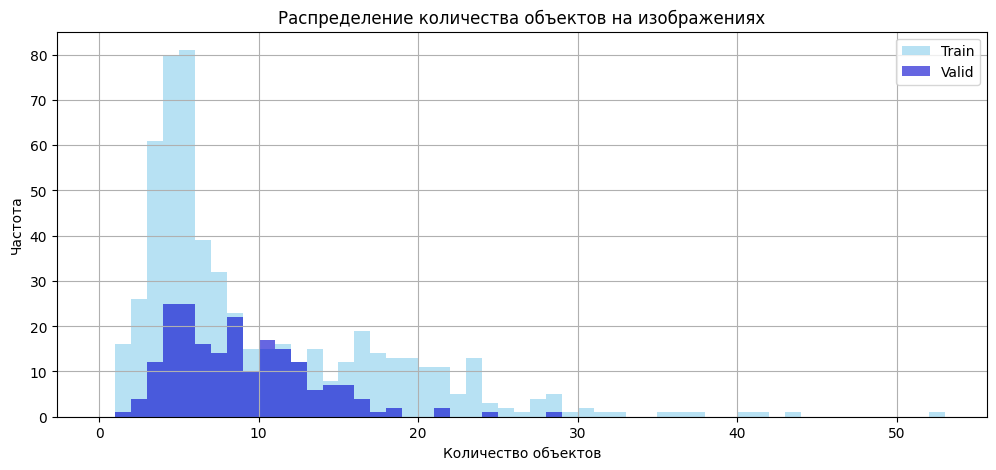

Среднее количество экземпляров на изображении (Train): 9, медиана: 6
Среднее количество экземпляров на изображении (Valid): 8, медиана: 8


In [ ]:
# Подсчёт количества экземпляров на изображениях
def object_count_distribution(label_files):
    counts = []

    for lbl in label_files:
        with open(lbl, 'r') as f:
            lines = f.readlines()
            counts.append(len(lines))

    return counts


# Количество экземпляров
train_counts = object_count_distribution(train_lbls)
valid_counts = object_count_distribution(valid_lbls)

# Точечный график распределения количества экземпляров на изображениях по их индексам
plt.figure(figsize=(12, 5))
plt.scatter(range(len(train_counts)), train_counts, label='Train', alpha=0.6, color='skyblue', s=25)
plt.scatter(range(len(valid_counts)), valid_counts, label='Valid', alpha=0.6, color='mediumblue', s=25)

plt.title("Распределение количества объектов на изображениях")
plt.xlabel("Индекс изображения")
plt.ylabel("Количество объектов (bbox)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График распределения частоты количества объектов на изображениях
plt.figure(figsize=(12, 5))
plt.hist(train_counts, bins=range(0, max(train_counts) + 2), alpha=0.6, label='Train', color='skyblue')
plt.hist(valid_counts, bins=range(0, max(valid_counts) + 2), alpha=0.6, label='Valid', color='mediumblue')

plt.title("Распределение количества объектов на изображениях")
plt.xlabel("Количество объектов")
plt.ylabel("Частота")
plt.legend()
plt.grid(True)
plt.show()

print(f'Среднее количество экземпляров на изображении (Train): {np.mean(train_counts):.0f}, медиана: {np.median(train_counts):.0f}')
print(f'Среднее количество экземпляров на изображении (Valid): {np.mean(valid_counts):.0f}, медиана: {np.median(valid_counts):.0f}')

По графикам видно, что некоторые изображения имеют аномально большое количество экземпляров на них, все эти изображения находятся в обучающей выборке. Это может помочь модели адаптироваться к сложным условиям, где частиц микропластика слишком много и они слишком мелкие. \
В валидационной выборке количество экземпляров не превышает 30.

### Визуализация примера аугментации

Этот пример показывает случайно выбранное изображение из тренировочной выборки и применённые к нему некоторые используемые аугментации. \
Такой анализ тоже важен, поскольку следует проверять, правильно ли применились аугментации к изображению: не слетела ли разметка при поворотах / отражениях? Не стали ли детали изображения неразличимыми? и т.д.

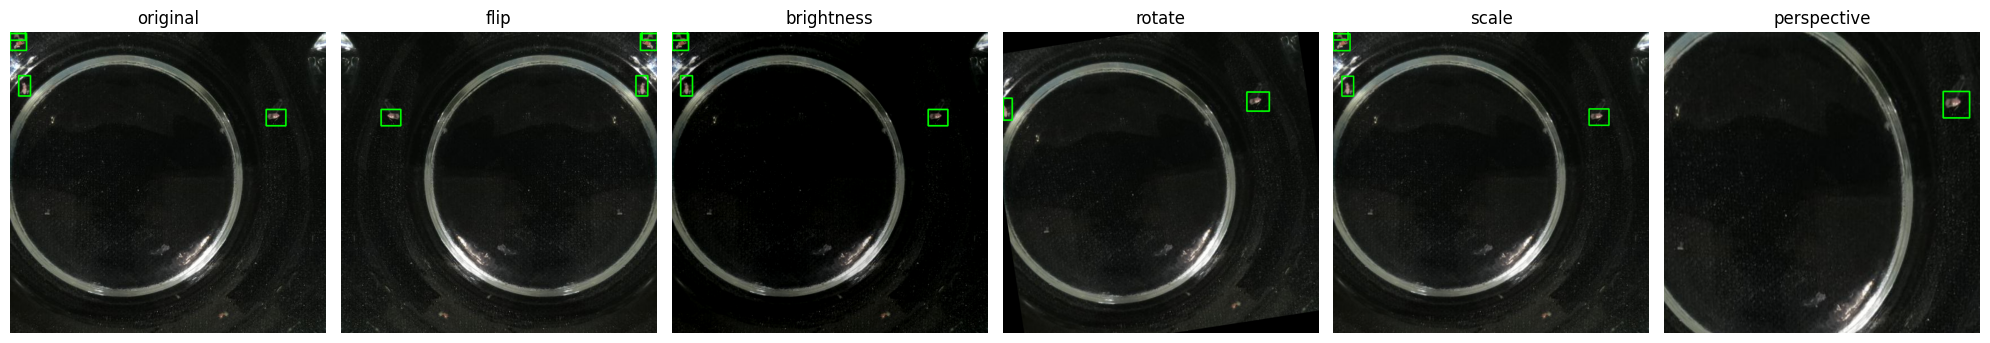

In [ ]:
# Применяемые аугментации
transformations = {
    "original": A.Compose([], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    "flip": A.Compose([A.HorizontalFlip(p=1.0)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    "brightness": A.Compose([A.RandomBrightnessContrast(p=1.0)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    "rotate": A.Compose([A.Rotate(limit=30, p=1.0)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    "scale": A.Compose([A.RandomScale(scale_limit=0.2, p=1.0)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    "perspective": A.Compose([A.Perspective(scale=(0.05, 0.1), p=1.0)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
}


# Загрузка изображений и аннотаций
def load_image_with_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    bboxes = []
    labels = []

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls, *box = map(float, parts)
            bboxes.append(box)
            labels.append(int(cls))

    return img, bboxes, labels


# Отрисовка bbox-ов
def draw_boxes(img, bboxes, color=(0, 255, 0), thickness=2):
    h_img, w_img = img.shape[:2]

    for box in bboxes:
        x, y, w, h = box
        x1 = int((x - w / 2) * w_img)
        y1 = int((y - h / 2) * h_img)
        x2 = int((x + w / 2) * w_img)
        y2 = int((y + h / 2) * h_img)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

    return img


# Визуализация аугментаций
def show_all_transforms(image_dir, labels_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    selected_idx = np.random.randint(0, len(image_files) - 1)
    image_name = image_files[selected_idx]
    label_name = os.path.splitext(image_name)[0] + ".txt"

    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(labels_dir, label_name)

    img, bboxes, labels = load_image_with_boxes(image_path, label_path)

    fig, axes = plt.subplots(1, len(transformations), figsize=(20, 5))
    for ax, (name, transform) in zip(axes, transformations.items()):
        aug = transform(image=img.copy(), bboxes=bboxes, class_labels=labels)
        img_aug = draw_boxes(aug['image'].copy(), aug['bboxes'])
        ax.imshow(img_aug)
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_all_transforms(train_images_dir, train_labels_dir)

По получившимся изображениям видно, что изоражения сохраняют правильную разметку, а также сохраняют читаемость. Это значит, что такая аугментация не должна навредить модели.

# Обучение модели

При применении аугментации важно примерно понимать, какие методы могут улучшить качество модели, а какие могут не повлиять на него или, наоборот, ухудшить. \
Например, в случае с распознаванием микропластика очень нежелательно добавлять шум на изображение или использовать размытие, т.к. это затруднит модели распознавание отдельных мелких частиц, и она не сможет отделить их от заднего фона. В свою очередь, различные повороты изображения не будут лишними в данной ситуации, т.к. частицы могут находиться в любом положении. \
Изначально планировалось использовать ручную выборочную аугментацию, т.к. Ultralytics имеет встроенную с широким выбором. Однако результаты обучения с ней оказались крайне скудными из-за сложности подбора правильных параметров. \
Поэтому для обучения была использована автоматическая аугментация, она основана на таких наборах данных, как ImageNet, CIFAR10 и SVHN. \
\
Подробнее: \
https://docs.ultralytics.com/ru/guides/yolo-data-augmentation/

In [ ]:
# Очистка кэша
torch.cuda.empty_cache()

In [ ]:
# Средняя по ресурсоемкости модель
model = YOLO('yolo12m.pt')

# Обучение
model.train(
    data='/content/Microplastic-Dataset-19/data.yaml', # Конфигурационный файл
    epochs=50, # Количество эпох
    imgsz=640, # Размер изображений
    batch=8, # Объём данных (примеров), обрабатываемых за раз
    name='yolo12m_microplastic_detection', # Название собственной модели
    device='cuda', # Устройство обработки (GPU)
    workers=2, # Количество потоков обработки

    # Аугментация
    auto_augment=True, # Автоматическая аугментация
    augment=False # Ручная аугментация

    # fliplr=0.5, # Вероятность горизонтального отражения
    # flipud=0.05, # Вероятность вертикального отражения
    # degrees=10, # Повороты изображения (0-15 градусов)
    # translate=0.15, # Сдвиг по X и Y
    # scale=0.5, # Масштабирование
    # shear=0.2, # Сдвиг по диагонали
    # perspective=0.1, # Перспективное искажение
    # hsv_h=0.05, # Изменение оттенка
    # hsv_s=0.7, # Изменение насыщенности
    # hsv_v=0.4, # Изменение яркости
    # copy_paste=0.1, # Копирование объектов между изображениями
    # mixup=0.1, # Микс двух разных изображений вместе
    # cutmix=0.05, # Выборочное замещение областей одного изображения другим
    # mosaic=1, # Смешивание 4 изображений
    # erasing=0.4 # Обнуление случайных участков изображения
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=True, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Microplastic-Dataset-19/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12m_microplastic_detection3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

train: Scanning /content/Microplastic-Dataset-19/train/labels.cache... 577 images, 0 backgrounds, 0 corrupt: 100%|██████████| 577/577 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 483.9±248.1 MB/s, size: 35.1 KB)


val: Scanning /content/Microplastic-Dataset-19/valid/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo12m_microplastic_detection3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0005), 129 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo12m_microplastic_detection3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.82G      2.144      1.855      1.575          2        640: 100%|██████████| 73/73 [00:32<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

                   all        204       1701     0.0957       0.13     0.0417      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.82G      2.251      1.782       1.64          2        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]

                   all        204       1701     0.0414     0.0223     0.0124    0.00649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.82G      2.241      1.588      1.576          5        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

                   all        204       1701      0.451      0.456      0.416      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.82G      2.146      1.503      1.542         13        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]

                   all        204       1701      0.219      0.278      0.183     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.82G      2.097      1.436      1.505          3        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]

                   all        204       1701      0.654       0.59      0.584      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.82G      2.141      1.414      1.519          2        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

                   all        204       1701      0.587      0.563      0.571      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.82G      2.082      1.386      1.487         14        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

                   all        204       1701      0.647      0.598      0.612      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.82G      2.062      1.346      1.467          2        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]

                   all        204       1701      0.664       0.62      0.644      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.82G      2.068      1.311      1.477         25        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

                   all        204       1701      0.593      0.535      0.537      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.82G      2.079       1.32      1.454          5        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

                   all        204       1701       0.68       0.64      0.662      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.82G      2.057      1.322      1.467         12        640: 100%|██████████| 73/73 [00:31<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]

                   all        204       1701      0.614       0.59      0.591      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.82G      2.033      1.313      1.449         15        640: 100%|██████████| 73/73 [00:30<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]

                   all        204       1701      0.676      0.622      0.654      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.82G      2.039      1.256      1.448         13        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

                   all        204       1701      0.693      0.586      0.621      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.82G      2.047      1.288      1.423         15        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.652       0.59      0.626      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.82G      1.976      1.198      1.432         15        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.715      0.611      0.654      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.82G      2.008      1.241      1.408         10        640: 100%|██████████| 73/73 [00:31<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]

                   all        204       1701      0.724      0.591      0.633      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.82G       1.99      1.226      1.407          2        640: 100%|██████████| 73/73 [00:31<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]

                   all        204       1701        0.7       0.65      0.687      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.82G      1.967       1.15      1.429         17        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

                   all        204       1701      0.705      0.607      0.655        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.82G      1.969      1.206      1.411         10        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]

                   all        204       1701      0.739      0.604      0.683      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.82G      1.967      1.159       1.39         11        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

                   all        204       1701      0.705      0.619      0.661      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.82G      1.967      1.149      1.398         17        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

                   all        204       1701      0.656      0.654      0.668      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.89G      1.944      1.139      1.414         10        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

                   all        204       1701      0.767      0.594      0.693      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.89G      1.955      1.135      1.401         23        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]

                   all        204       1701      0.743      0.635      0.701      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.89G      1.974      1.188      1.416          6        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.745      0.602      0.681      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.89G      1.956      1.184      1.394          2        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

                   all        204       1701      0.745      0.613      0.687      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.89G      1.935      1.117      1.368         12        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

                   all        204       1701      0.764      0.626      0.683      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.89G      1.938       1.11      1.391          2        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.763      0.603      0.688      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.89G      1.947       1.13      1.377         30        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]

                   all        204       1701      0.773      0.601      0.686      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.89G       1.89      1.122      1.376          6        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.25it/s]

                   all        204       1701      0.731      0.632      0.691      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.89G       1.89      1.105      1.354         35        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

                   all        204       1701      0.762      0.646      0.702      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.89G      1.879      1.101      1.363          5        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]

                   all        204       1701      0.773      0.621      0.696      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.89G      1.881      1.056      1.355          5        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]

                   all        204       1701      0.768      0.643      0.691       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.89G      1.894      1.066      1.374          4        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]

                   all        204       1701      0.769      0.614      0.708      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.89G      1.918      1.088      1.357         17        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]

                   all        204       1701      0.796      0.626      0.723      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.89G      1.882      1.052      1.369         11        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]

                   all        204       1701      0.777      0.662      0.734       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.89G      1.876      1.039      1.344          8        640: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

                   all        204       1701      0.778      0.651      0.729      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.89G      1.883      1.056      1.333         27        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

                   all        204       1701      0.778      0.627      0.709      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.89G      1.881      1.039      1.342         13        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

                   all        204       1701      0.783      0.635      0.721      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.89G      1.867      1.049      1.352         14        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]

                   all        204       1701      0.774      0.653      0.717      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.89G      1.859       1.05      1.341          8        640: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]

                   all        204       1701      0.783      0.599      0.686      0.335


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.89G      1.865      1.032      1.382          5        640: 100%|██████████| 73/73 [00:31<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.779      0.653      0.717      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.89G      1.862      1.022      1.383          2        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        204       1701      0.789      0.629      0.717      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.89G      1.853      1.035      1.394         17        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]

                   all        204       1701      0.777      0.619      0.703      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.89G       1.85     0.9951      1.373          4        640: 100%|██████████| 73/73 [00:30<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]

                   all        204       1701      0.785      0.636       0.71      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.89G       1.84     0.9937      1.384          4        640: 100%|██████████| 73/73 [00:30<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

                   all        204       1701      0.806      0.626      0.714      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.89G       1.82     0.9795      1.376          2        640: 100%|██████████| 73/73 [00:30<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

                   all        204       1701      0.778      0.632      0.706      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.89G      1.809     0.9639      1.358          5        640: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

                   all        204       1701      0.809      0.631      0.707      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.89G      1.829     0.9487      1.363          6        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]

                   all        204       1701      0.796      0.651      0.723      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.89G      1.842     0.9542      1.385         21        640: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]

                   all        204       1701      0.806      0.644      0.721      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.89G      1.791     0.9453      1.346          4        640: 100%|██████████| 73/73 [00:30<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]

                   all        204       1701      0.817      0.638      0.727      0.355



50 epochs completed in 0.506 hours.
Optimizer stripped from runs/detect/yolo12m_microplastic_detection3/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/yolo12m_microplastic_detection3/weights/best.pt, 40.8MB

Validating runs/detect/yolo12m_microplastic_detection3/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,105,683 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


                   all        204       1701      0.818      0.638      0.727      0.354
Speed: 0.3ms preprocess, 16.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/yolo12m_microplastic_detection3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa62b1f0e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Повторная очистка кэша
torch.cuda.empty_cache()

По логам обучения модели заметно, что 50 эпох достаточно для получения хороших результатов. \
Под конец обучения Recall перестал увеличиваться, а остальные метрики все ещё продолжали расти. Но это не имеет большого значения, т.к. показатели у них хорошие, а наиболее важной метрикой для данной задачи является именно Recall. \
Модель можно было обучить на 100 эпохах, вероятно это дало бы чуть лучшие результаты, однако Google Colab имеет довольно строгое ограничение по времени использования вычислительных мощностей T4 GPU, что заставляет урезать количество эпох обучения.

# Оценка качества модели

В результате обучения модель выдаёт вполне неплохие результаты. При оценке модели используются такие метрики, как **mAP@50** и **mAP@50:95**. \
**mAP (Mean Average Precision)** является одной из основных метрик оценки качества моделей детекции. Она является компромиссом между **Precision** и **Recall**. \
mAP@50 обозначает оценку средней точности модели при условии, что IoU >= 0.5 \
mAP@50-95 обозначает значение средней точности, рассчитанное при различных пороговых значениях IoU, варьирующихся от 0,50 до 0,95. Этот показатель даёт полную оценку модели на разных уровнях порога обнаружения. \
В данной задаче Recall является приоритетной метрикой, т.к. здесь полнота важнее точности.

## Метрики модели


In [ ]:
metrics = model.val() # Валидация
curves = metrics.box.curves # Получение графиков метрик

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1247.2±413.1 MB/s, size: 32.1 KB)


val: Scanning /content/Microplastic-Dataset-19/valid/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  3.01it/s]


                   all        204       1701      0.805      0.646      0.727      0.355
Speed: 1.1ms preprocess, 30.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/yolo12m_microplastic_detection35


## Визуализация результатов

### Графики метрик

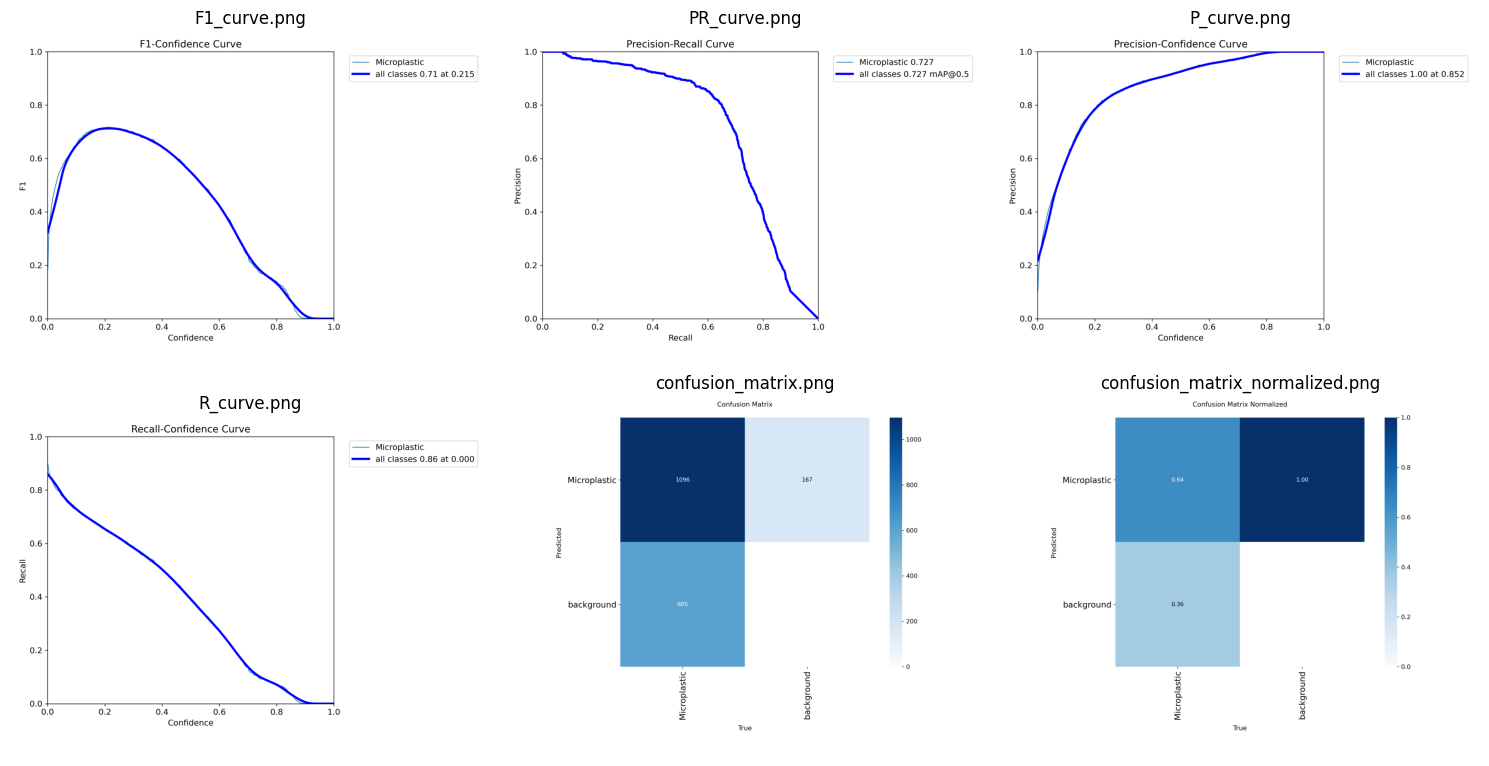

In [ ]:
# Путь к эксперименту
exp_dir = '/content/runs/detect/yolo12m_microplastic_detection35'

image_files = [
    'F1_curve.png',
    'PR_curve.png',
    'P_curve.png',
    'R_curve.png',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png'
]

# Отображение графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, fname in zip(axes, image_files):
    img_path = os.path.join(exp_dir, fname)

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(fname)
        ax.axis('off')

    else:
        ax.set_title(f'{fname} (not found)')
        ax.axis('off')

plt.tight_layout()
plt.show()

На этих графиках визуализирована эффективность модели в данной задаче. \
**F1_curve:** Показывает зависимость F1-score от порога уверенности определения экземпляра. По графику видно, что наибольший показатель F1-score принимает при пороге уверенности, равном 0.215. \
**PR_curve:** Показывает зависимость Precision и Recall. Из него понятно, что при высокой полноте модель теряет точность. \
**P_curve:** Показывает зависимость точности от порога уверенности определения экземпляра. С порогом уверенности точность возрастает. \
**R_curve:** Показывает зависимость полноты от порога уверенности. Чем выше порог, тем меньше полнота. Для данной задачи подходят значения в диапазоне: 0.2 - 0.3. \
**confusion_matrix:** Показывает матрицу ошибок. По этой матрице видно, что модель, почти не путает фон с объектами, но довольно часто их пропускает. \
**confusion_matrix_normalized:** Показывает нормализованную матрицу ошибок.

### Матрица коррелограмм

Матрица коррелограмм (pairplot) предназначена для визуального анализа распределения и взаимосвязей параметров bbox-ов. \
Она позволяет определить распределение экземпляров по изображению, размер экземпляров и аномалии.

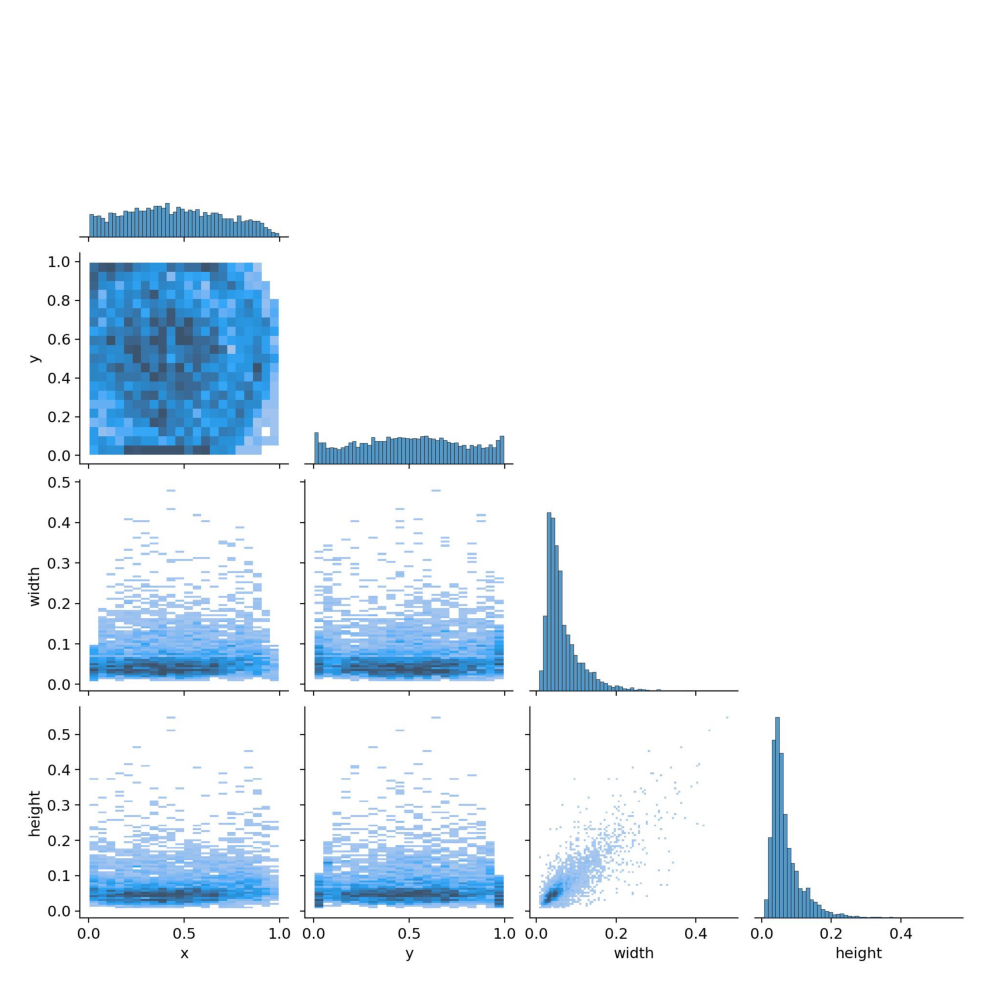

In [ ]:
img_path = '/content/runs/detect/yolo12m_microplastic_detection/labels_correlogram.jpg'

# Отображение графика
plt.figure(figsize=(18, 10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.tight_layout()
plt.imshow(img)

По данной матрице видно, что экземпляры расположены в основном в центре изображений, но по краям снизу и сверху слева тоже расположено много объектов. \
Объекты, в основном, имеют очень маленькие размеры, что объясняет не самый высокий Recall \
Большинство экземпляров имеют форму, близкую к квадратной.

## Проверка на случайных данных


0: 640x640 5 Microplastics, 39.7ms
1: 640x640 16 Microplastics, 39.7ms
2: 640x640 4 Microplastics, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


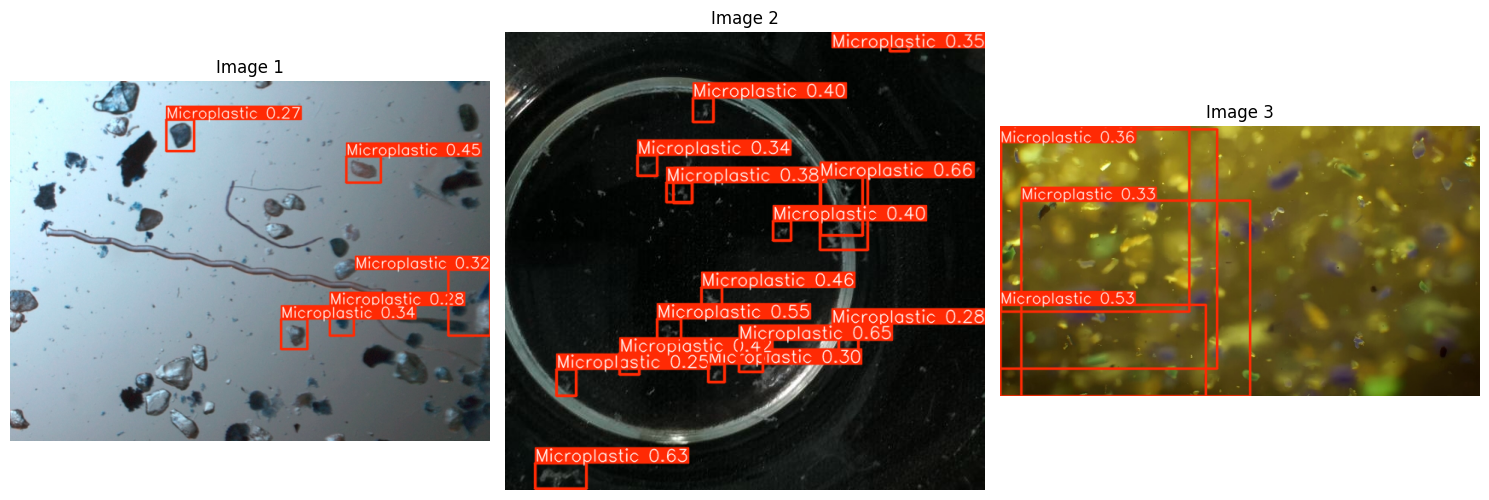

In [ ]:
results = model(['1.jpg', '2.jpg', '3.jpg'])

fig, axs = plt.subplots(1, len(results), figsize=(5 * len(results), 5))

for i, res in enumerate(results):
    img = res.plot()
    axs[i].imshow(img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Результаты показывают, что на случайных изображениях из интернета модель показывает себя не очень хорошо, в отличие от схожего с изображениями валидационной выборки. Это связано со спецификой изображений из выборки: в ней все снимки имеют почти одинаковый фон, а также чатицы пластика имеют очень бледный оттенок.